# Кластеризация временных рядов

In [1]:
# pip install cryptocompare
# https://blog.quantinsti.com/download-cryptocurrency-data-python-cryptocompare-api/

#### Импорт библиотек

In [1]:
import cryptocompare

import pandas as pd
from datetime import datetime
from sklearn import preprocessing
import numpy as np

from tqdm.auto import tqdm
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
btc_price_day = cryptocompare.get_historical_price_day('BTC', limit=30)

### Рассмотрим цены закрытия для BTC

Перед тем, как начинать кластеризацию, посмотрим данные BTC, попробуем их покрутить и понять, какими данными владеем.

In [3]:
#за последние 30 дней с дневной частотой

btc_price_day = cryptocompare.get_historical_price_day('BTC', currency='USD', limit=30)

df_btc_price_day = pd.DataFrame(btc_price_day, columns=['time', 'close'])

df_btc_price_day['datetime'] = [datetime.fromtimestamp(x) for x in df_btc_price_day['time']]

df_btc_price_day['date'] = pd.to_datetime(df_btc_price_day['time'], unit='s')

#за последние 3 дня с часовой частотой

btc_price_hour = cryptocompare.get_historical_price_hour('BTC', currency='USD', limit=3*24)

df_btc_price_hour = pd.DataFrame(btc_price_hour, columns=['time', 'close'])

df_btc_price_hour['datetime'] = [datetime.fromtimestamp(x) for x in df_btc_price_hour['time']]

#за последний час с минутной частотой

btc_price_minute = cryptocompare.get_historical_price_minute('BTC', currency='USD', limit=60)

df_btc_price_minute = pd.DataFrame(btc_price_minute, columns=['time', 'close'])

df_btc_price_minute['datetime'] = [datetime.fromtimestamp(x) for x in df_btc_price_minute['time']]

In [4]:
df_btc_price_day.head()

,time,close,datetime,date
0,1687478400,30700.29,2023-06-23 03:00:00,2023-06-23
1,1687564800,30548.03,2023-06-24 03:00:00,2023-06-24
2,1687651200,30473.33,2023-06-25 03:00:00,2023-06-25
3,1687737600,30274.61,2023-06-26 03:00:00,2023-06-26
4,1687824000,30698.21,2023-06-27 03:00:00,2023-06-27


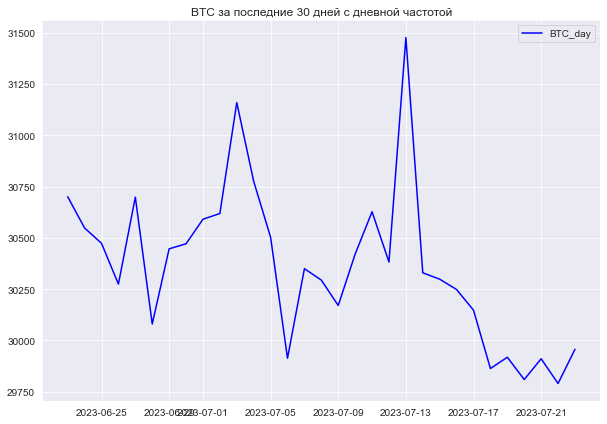

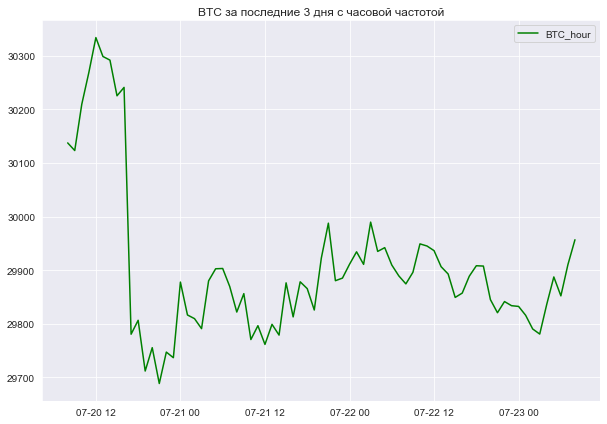

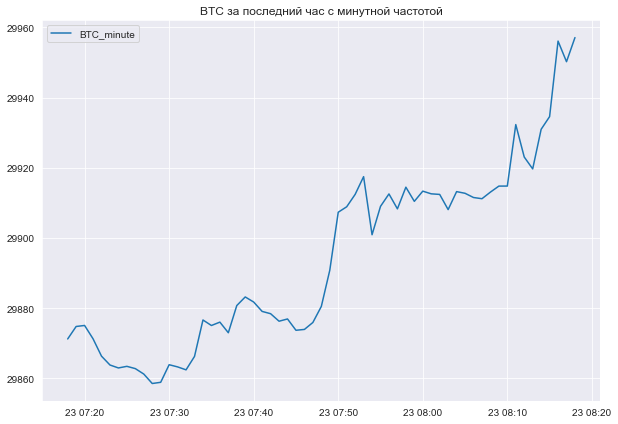

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(df_btc_price_day['date'], df_btc_price_day['close'], label='BTC_day', color='blue')
plt.legend()
plt.title("BTC за последние 30 дней с дневной частотой")
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(df_btc_price_hour['datetime'], df_btc_price_hour['close'], label='BTC_hour', color='green')
plt.legend()
plt.title("BTC за последние 3 дня с часовой частотой")
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(df_btc_price_minute['datetime'], df_btc_price_minute['close'], label='BTC_minute')
plt.title("BTC за последний час с минутной частотой")
plt.legend()
plt.show()

#### Нормализация

Перед тем, как проводить кластеризацию, необходимо нормализовать данные. Посмотроим несколько способов и выбирем необходимый для нашей кластеризации.

https://dev-gang.ru/article/-prostyh-sposoba-normalizovat-dannye-v-python-7qqrhmlppl/

https://www.helenkapatsa.ru/minmaxscaler/

In [6]:
x_array = np.array(df_btc_price_day['close'])
normalized_arr = preprocessing.normalize([x_array])
df_btc_price_day['close_normolize'] = normalized_arr.reshape(-1)

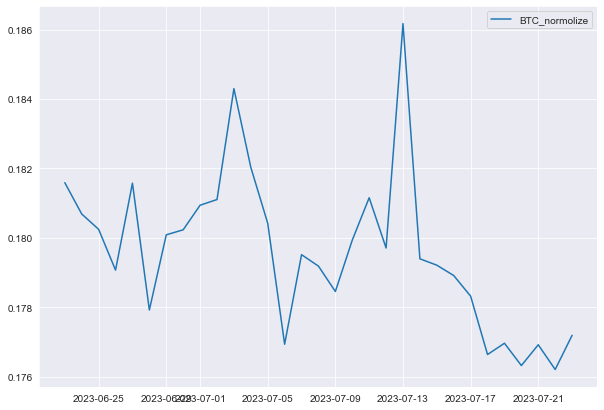

In [7]:
plt.figure(figsize=(10, 7))
plt.plot(df_btc_price_day['date'], df_btc_price_day['close_normolize'], label='BTC_normolize')
plt.legend()
plt.show()

In [8]:
x = df_btc_price_day.values[:, 1 : 2] #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_btc_price_day['close_normolize_scaler'] = pd.DataFrame(x_scaled)

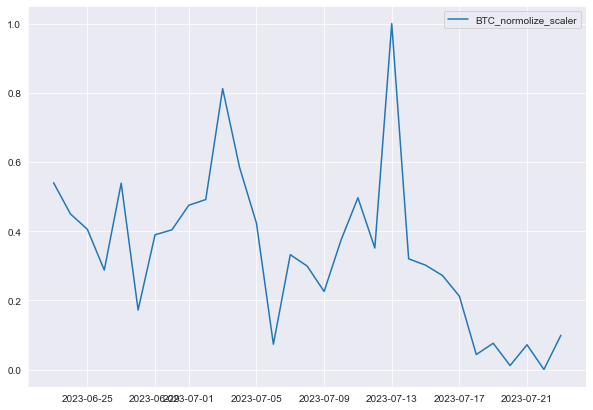

In [9]:
plt.figure(figsize=(10, 7))
plt.plot(df_btc_price_day['date'], df_btc_price_day['close_normolize_scaler'], label='BTC_normolize_scaler')
plt.legend()
plt.show()

### Соберем данные и по остальным криптовалютам

In [10]:
# Получаем список криптовалют
df_crypto_coint_list = cryptocompare.get_coin_list(format=True)

# Отбираем первые 100
df_crypto_coint_list = df_crypto_coint_list[:100]

# Добавляем BTC, так как он не попал к нам в список
df_crypto_coint_list.append('BTC')

df_crypto_coint_list.index('BTC')

df_coin_price_day = pd.DataFrame()

for coin in df_crypto_coint_list:
    coin_price_day = cryptocompare.get_historical_price_day(coin, currency='USD', limit=30)
    coin_price_day = pd.DataFrame(coin_price_day, columns=['time', 'close'])
    coin_price_day['datetime'] = [datetime.fromtimestamp(x) for x in coin_price_day['time']]
    coin_price_day.drop(columns = {'time'}, inplace = True)
    coin_price_day['coin_name'] = coin
    df_coin_price_day = pd.concat([coin_price_day, df_coin_price_day])

name_coin = df_coin_price_day['coin_name'].reset_index(drop = True).drop_duplicates().tolist()

[ERROR] CCCAGG market does not exist for this coin pair (XPY-USD)
[ERROR] CCCAGG market does not exist for this coin pair (DT-USD)
[ERROR] CCCAGG market does not exist for this coin pair (42-USD)
[ERROR] CCCAGG market does not exist for this coin pair (AC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (AERO-USD)
[ERROR] CCCAGG market does not exist for this coin pair (ALF-USD)
[ERROR] CCCAGG market does not exist for this coin pair (AEGIS-USD)
[ERROR] CCCAGG market does not exist for this coin pair (AMERICANCOIN-USD)
[ERROR] CCCAGG market does not exist for this coin pair (ALIEN-USD)
[ERROR] CCCAGG market does not exist for this coin pair (AURORAC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (AXR-USD)
[ERROR] CCCAGG market does not exist for this coin pair (BETACOIN-USD)
[ERROR] CCCAGG market does not exist for this coin pair (BLU-USD)
[ERROR] CCCAGG market does not exist for this coin pair (BOST-USD)
[ERROR] CCCAGG market does not exist for this coin pair

In [11]:
df_coin_price_day_p = df_coin_price_day.pivot(index = 'coin_name', columns='datetime', values='close')

In [12]:
df_coin_price_day_p.head()

datetime,2023-06-23 03:00:00,2023-06-24 03:00:00,2023-06-25 03:00:00,2023-06-26 03:00:00,2023-06-27 03:00:00,2023-06-28 03:00:00,2023-06-29 03:00:00,2023-06-30 03:00:00,2023-07-01 03:00:00,2023-07-02 03:00:00,...,2023-07-14 03:00:00,2023-07-15 03:00:00,2023-07-16 03:00:00,2023-07-17 03:00:00,2023-07-18 03:00:00,2023-07-19 03:00:00,2023-07-20 03:00:00,2023-07-21 03:00:00,2023-07-22 03:00:00,2023-07-23 03:00:00
coin_name,,,,,,,,,,,,,,,,,,,,,
2015,0.029170,0.029020,0.028950,0.028760,0.029160,0.028580,0.028920,0.028950,0.029060,0.029090,...,0.028810,0.028780,0.028740,0.028640,0.028370,0.028420,0.028320,0.028420,0.028300,0.006290
ACOIN,0.006627,0.006566,0.006648,0.006507,0.006614,0.006396,0.006482,0.006767,0.006735,0.006781,...,0.006593,0.006568,0.006539,0.006499,0.006453,0.006422,0.006432,0.006432,0.006345,0.006755
ARCH,0.018420,0.018330,0.018280,0.018160,0.018420,0.018050,0.018270,0.018280,0.018350,0.018370,...,0.018200,0.018180,0.018150,0.018090,0.017920,0.017950,0.017890,0.017950,0.017870,0.017970
BEAN,0.000921,0.000916,0.000914,0.000908,0.000921,0.000902,0.000913,0.000914,0.000918,0.000919,...,0.000910,0.000909,0.000907,0.000904,0.000896,0.000897,0.000894,0.000897,0.000894,0.000899
BTC,30700.290000,30548.030000,30473.330000,30274.610000,30698.210000,30080.240000,30446.530000,30471.000000,30590.710000,30618.420000,...,30329.630000,30298.630000,30248.170000,30147.600000,29863.320000,29918.310000,29809.670000,29910.930000,29790.370000,29953.480000


### Нормализация

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_coin_price_day_p.T).T
x_scaled_inv = min_max_scaler.inverse_transform(x_scaled.T)

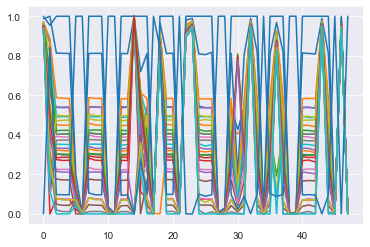

In [14]:
plt.plot(x_scaled)

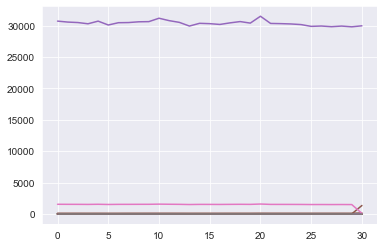

In [15]:
plt.plot(x_scaled_inv)

# Кластеризация DTW (Dynamic Time Warping)

https://ranalytics.github.io/tsa-with-r/ch-ts-clustering-by-raw-data.html#dtw-расстояние

 Алгоритм DTW трансформирует временную шкалу (растягивает или сжимает) с целью достичь оптимального сопоставления (optimal matching), или оптимального выравнивания (optimal alignment), двух последовательностей. Проще говоря, ставится задача расположить два временных ряда относительно друг друга таким образом, чтобы расстояние между ними оказалось минимальным.

<img src="../image/algo_dtw.png" alt="isolated"/>

  0%|          | 0/8 [00:00<?, ?it/s]

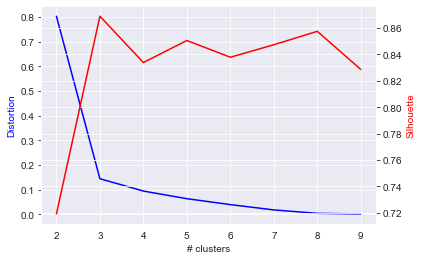

In [17]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
    kmeanModel.fit(x_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(x_scaled, kmeanModel.labels_, metric="dtw"))


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

In [18]:
n_clusters = 5

ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(x_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=5, n_jobs=6)

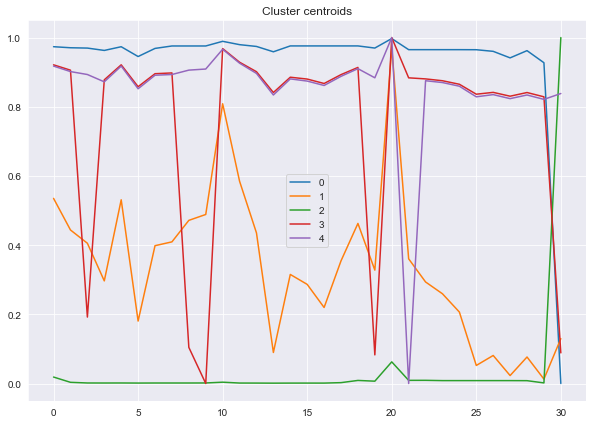

In [19]:
plt.figure(figsize=(10, 7))

for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [21]:
cluster_labels = ts_kmeans_dtw.fit_predict(x_scaled)

df_coin_price_day_p['cluster'] = cluster_labels

ts_clustered = [x_scaled[(cluster_labels == lable), :] for lable in np.unique(cluster_labels)]

In [23]:
int(np.ceil(df_coin_price_day_p.shape[0]/4))

12

In [28]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{current_cluster.index[index]}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


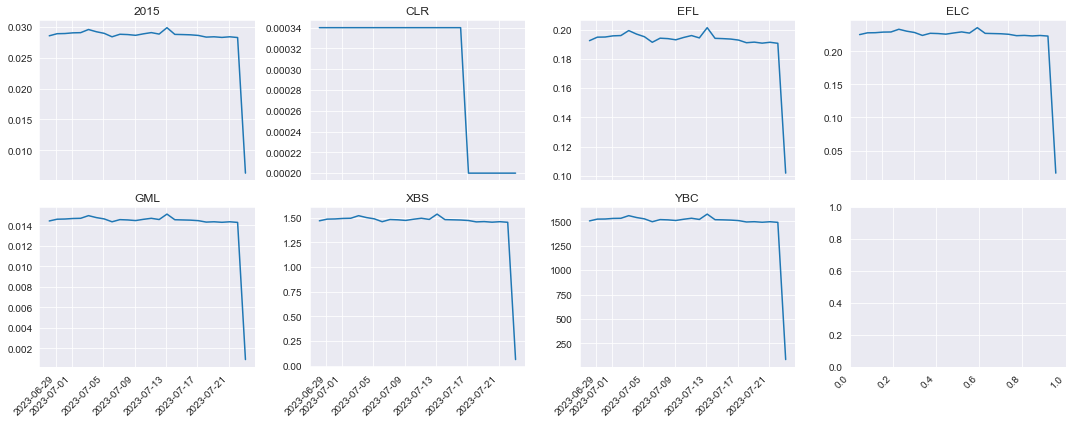

                          Cluster number: 1


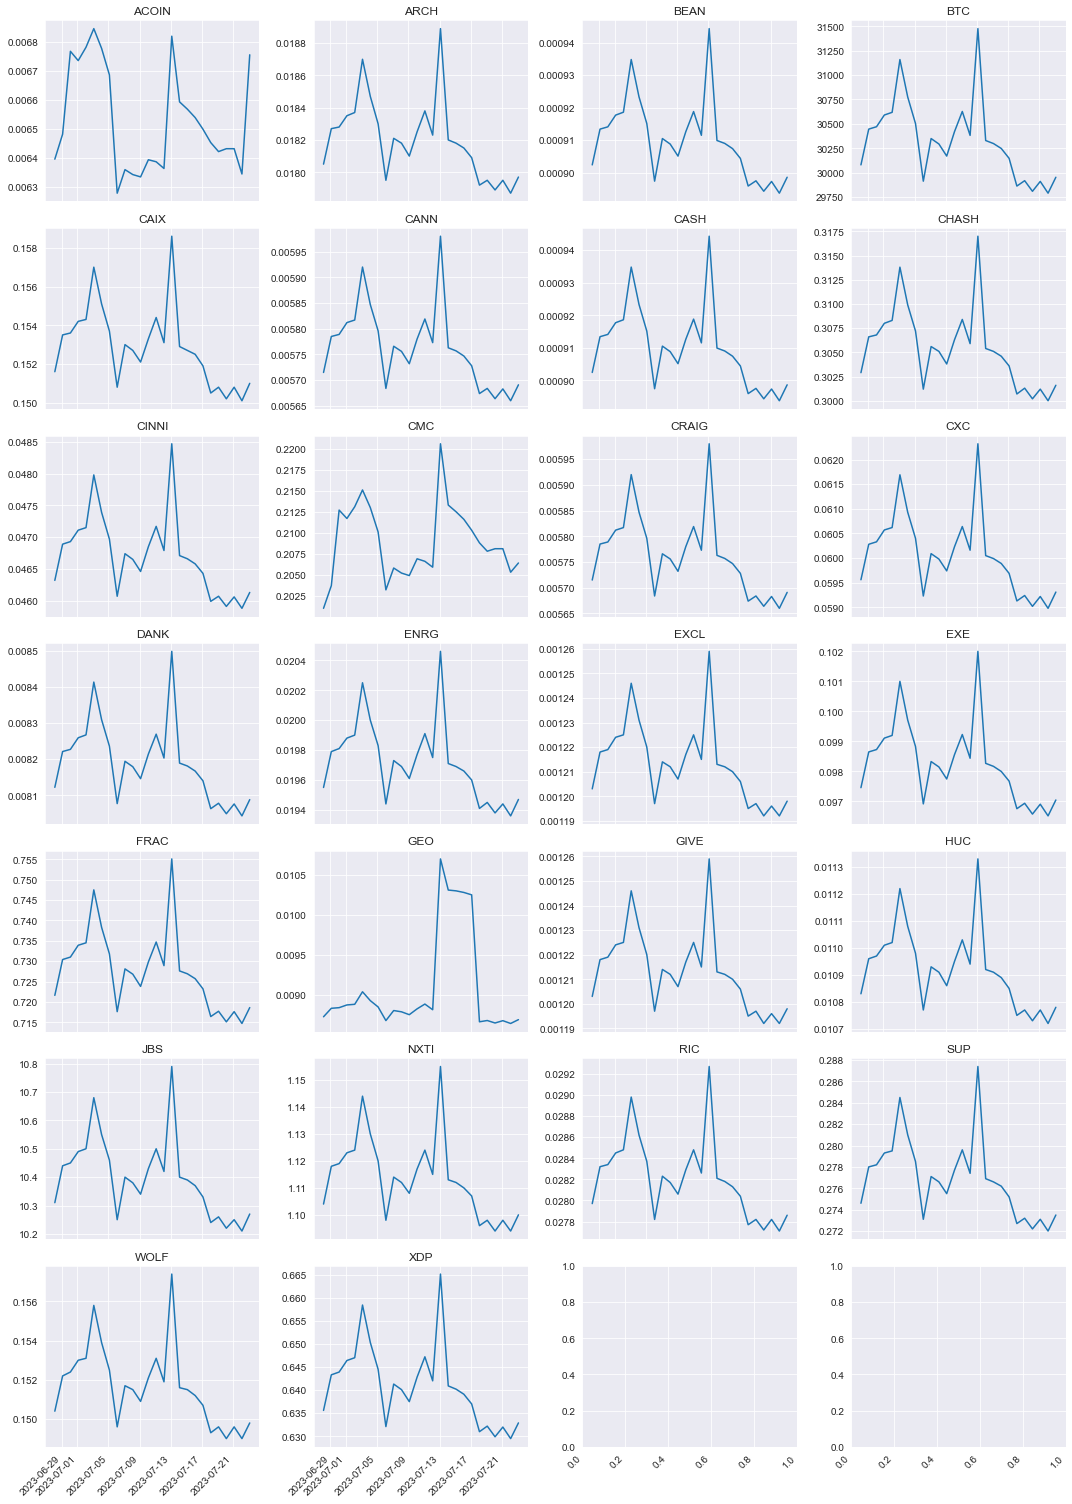

                          Cluster number: 2


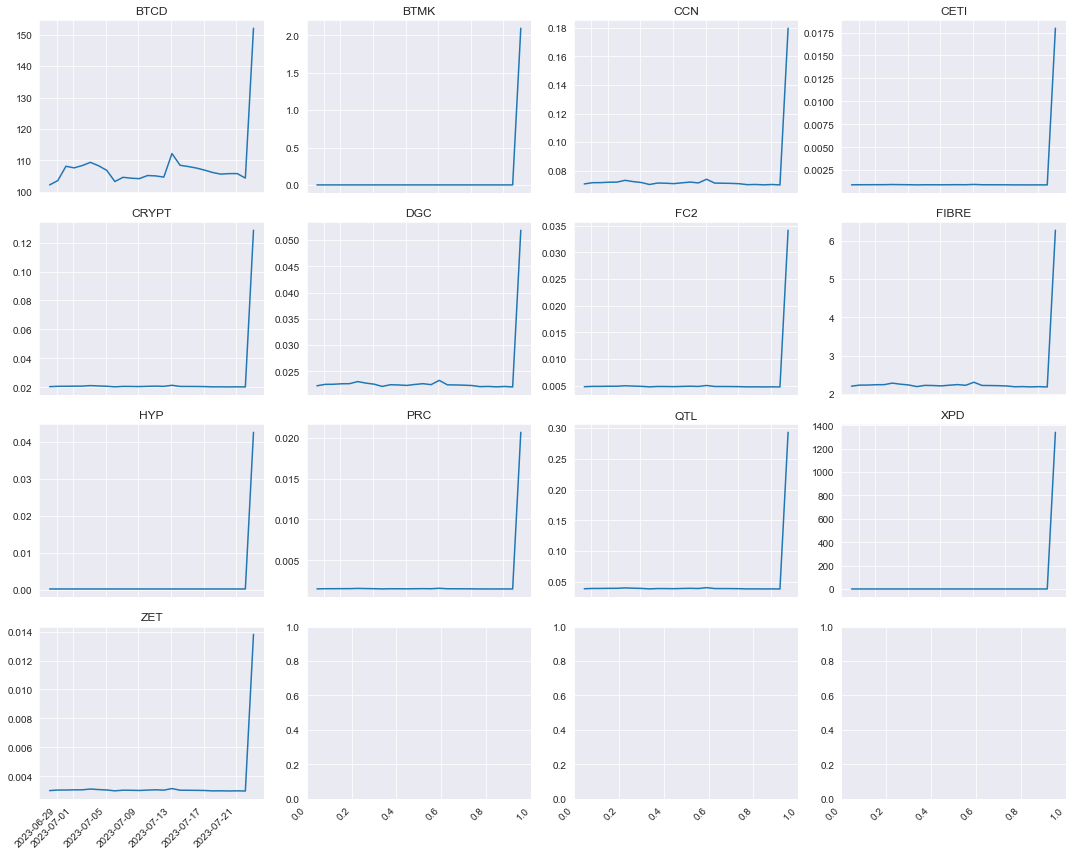

                          Cluster number: 3


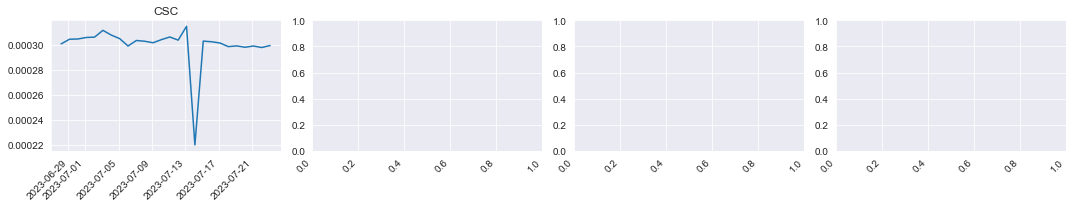

                          Cluster number: 4


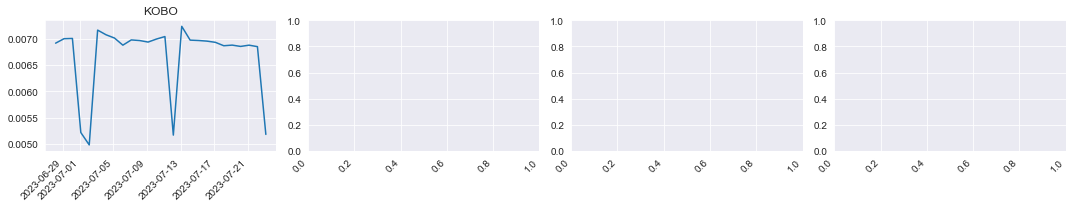

In [33]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(df_coin_price_day_p[df_coin_price_day_p.cluster==cluster])

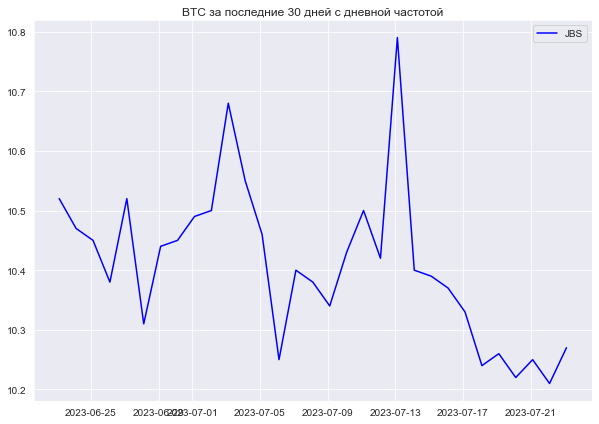

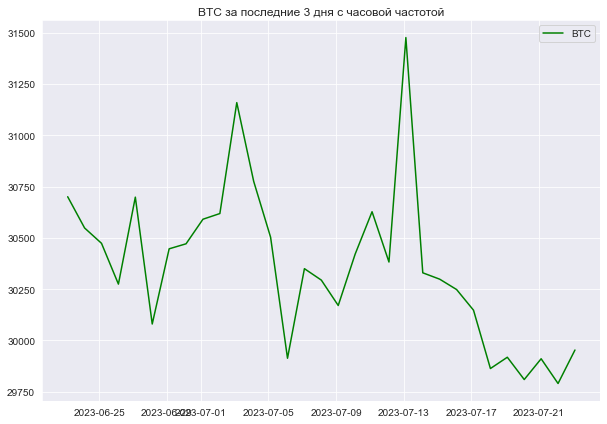

In [55]:
plt.figure(figsize=(10, 7))
plt.plot(df_coin_price_day[df_coin_price_day['coin_name'] == 'JBS']['datetime'], df_coin_price_day[df_coin_price_day['coin_name'] == 'JBS']['close'], label='JBS', color='blue')
plt.legend()
plt.title("BTC за последние 30 дней с дневной частотой")
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(df_coin_price_day[df_coin_price_day['coin_name'] == 'BTC']['datetime'], df_coin_price_day[df_coin_price_day['coin_name'] == 'BTC']['close'], label='BTC', color='green')
plt.legend()
plt.title("BTC за последние 3 дня с часовой частотой")
plt.show()

# Euclidean

  0%|          | 0/8 [00:00<?, ?it/s]

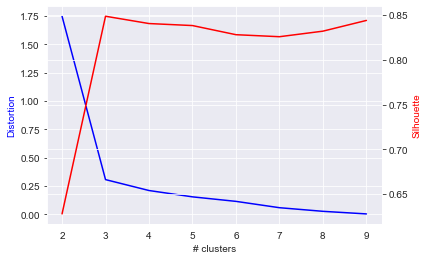

In [56]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10)
    kmeanModel.fit(x_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(x_scaled, kmeanModel.labels_, metric="euclidean"))


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

In [59]:
n_clusters = 3

ts_kmeans_ecl = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans_ecl.fit(x_scaled)

TimeSeriesKMeans(max_iter=10, n_jobs=6)

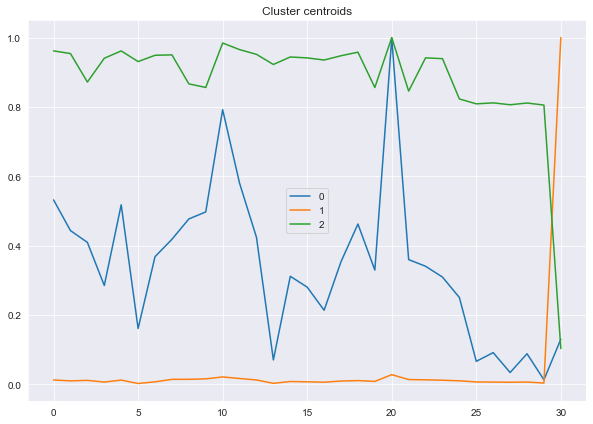

In [60]:
plt.figure(figsize=(10, 7))

for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_ecl.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [62]:
df_coin_price_day_ecl = df_coin_price_day.pivot(index='coin_name', columns='datetime', values='close')

cluster_labels = ts_kmeans_dtw.fit_predict(x_scaled)

df_coin_price_day_ecl['cluster'] = cluster_labels

ts_clustered = [x_scaled[(cluster_labels == lable), :] for lable in np.unique(cluster_labels)]

                          Cluster number: 0


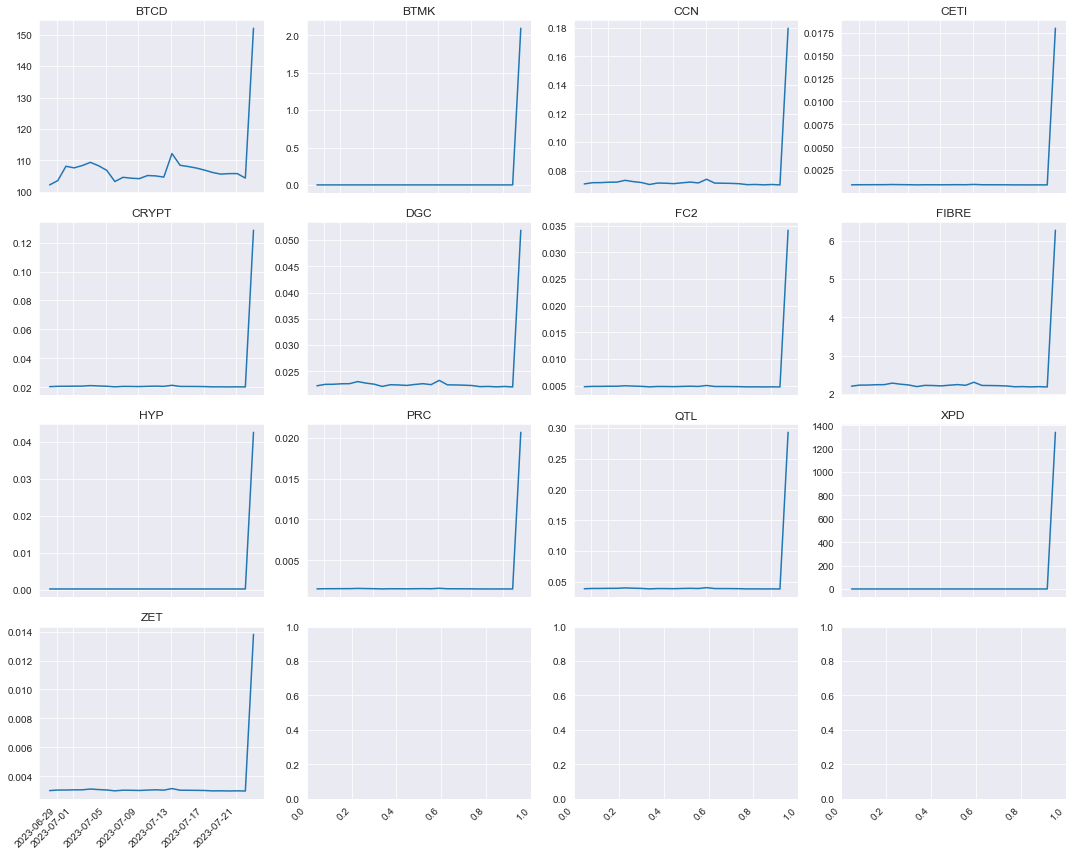

                          Cluster number: 1


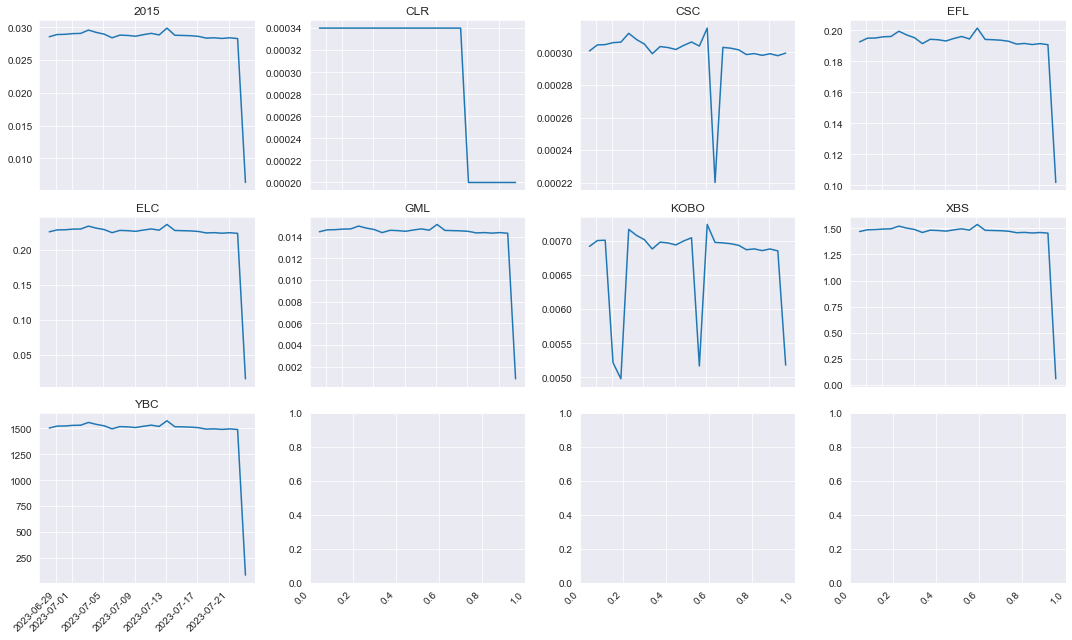

                          Cluster number: 2


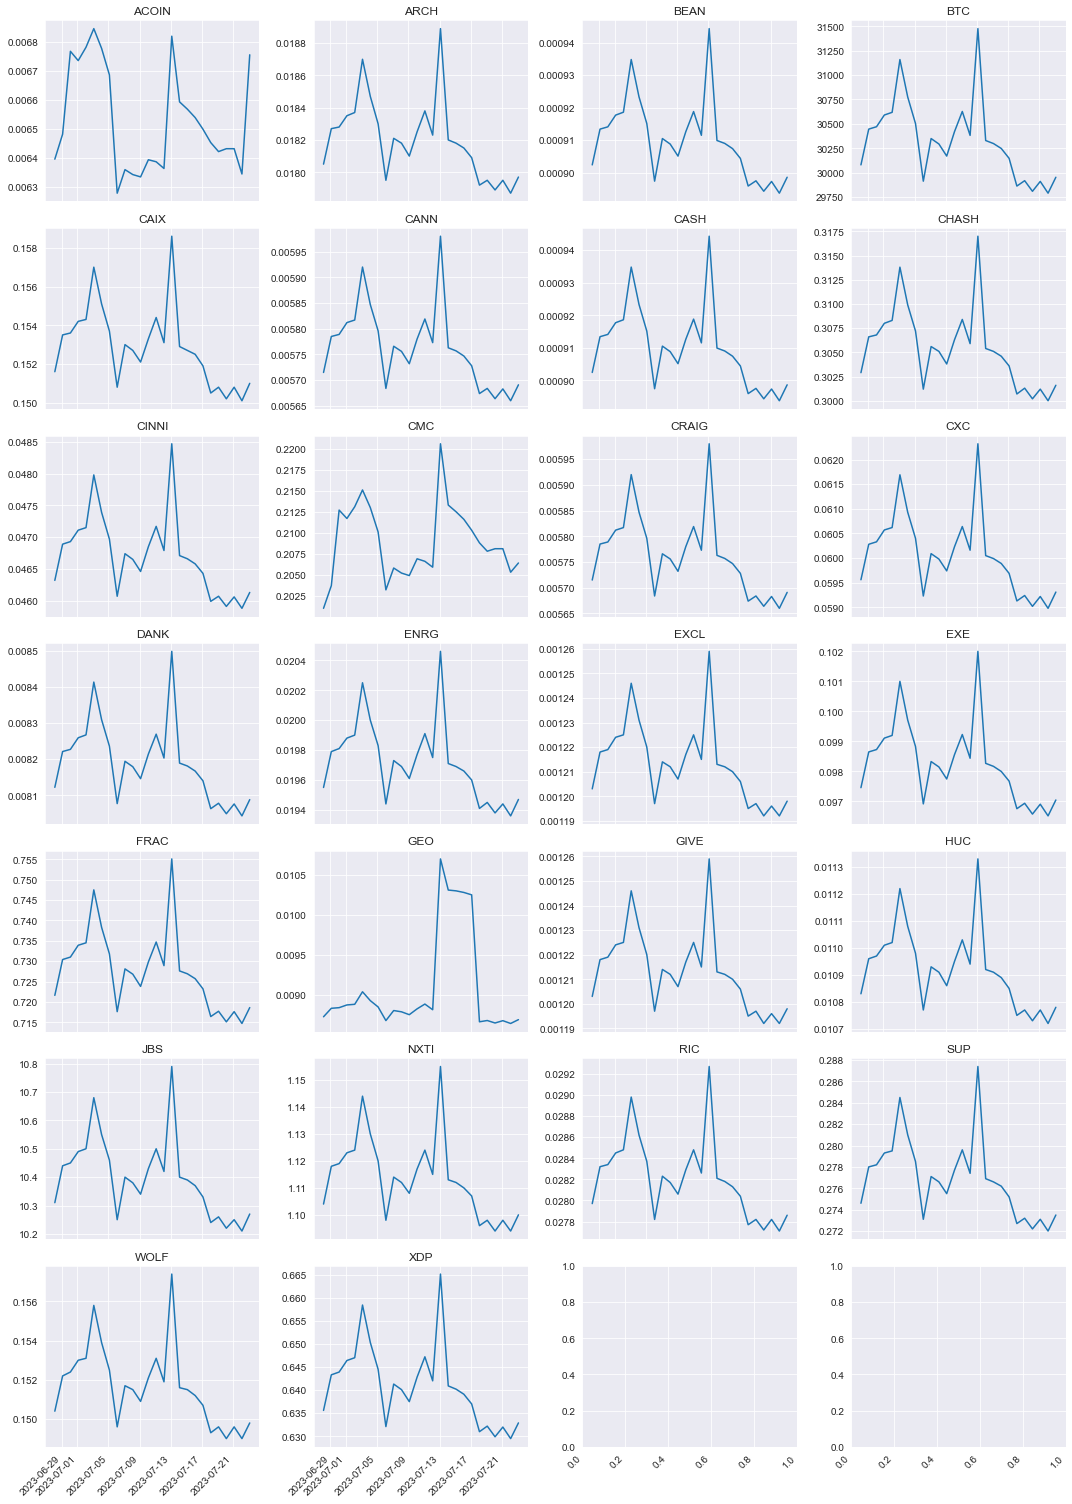

In [63]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(df_coin_price_day_ecl[df_coin_price_day_ecl.cluster==cluster])